In [1]:
# Imports
import ahrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from IPython.display import Image, Latex, clear_output
from scipy.spatial.transform import Rotation
from tqdm.auto import tqdm as tqdm
tqdm.pandas(desc="Progress")

In [2]:
# Metadata
header_rows = 3
# engine='pyarrow'
engine='python'
nrows=1e6
input_file = "DATA.CSV"

In [3]:
# Load data
df = pd.read_csv(input_file, header=header_rows, engine=engine, nrows=nrows)

In [4]:
df["_time"] = pd.to_datetime(pd.to_numeric(df["_time"]), unit="ms")

In [5]:
data = df[["_time", "_field", "_value"]].set_index(["_time","_field"]).unstack().droplevel(0, axis=1)

In [6]:
data

_field,Acc x,Acc y,Acc z,B,DHT hum,DHT temp,G,Gyro x,Gyro y,Gyro z,Humidity,Intensity,Mag x,Mag y,Mag z,PDM,Pressure,Proximity,R,Temperature
_time,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:03.743,-0.09,0.98,0.03,255.0,62.8,25.3,0.0,0.49,0.31,0.12,60.31,255.0,-0.42,55.35,-11.83,-78.00,1010.97,0.0,0.0,26.53
1970-01-01 00:00:04.419,-0.09,0.98,0.03,0.0,62.8,25.3,0.0,0.55,0.24,0.37,59.94,105.0,3.71,55.96,-10.05,-21.75,1010.56,150.0,255.0,26.77
1970-01-01 00:00:05.097,-0.09,0.98,0.03,0.0,62.8,25.3,0.0,0.37,0.43,0.06,60.01,105.0,-0.15,55.46,-11.05,1.00,1010.96,150.0,255.0,26.84
1970-01-01 00:00:05.770,-0.09,0.98,0.03,0.0,57.9,25.4,0.0,0.49,0.49,0.37,59.79,41.0,2.67,56.64,-10.35,-26.00,1010.98,214.0,255.0,26.90
1970-01-01 00:00:06.462,-0.09,0.98,0.03,0.0,57.9,25.4,0.0,0.49,0.49,0.12,59.60,41.0,-0.65,55.04,-11.51,5.25,1010.97,214.0,255.0,26.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 09:31:57.690,-0.06,0.98,0.01,255.0,46.7,24.1,0.0,0.55,0.55,0.31,42.64,32.0,-0.93,55.57,-12.63,8.75,1011.30,223.0,0.0,29.87
1970-01-01 09:31:58.362,-0.06,0.98,0.01,255.0,46.7,24.1,0.0,0.55,0.55,0.24,42.54,32.0,-0.56,56.12,-12.73,-8.50,1011.26,223.0,0.0,29.87
1970-01-01 09:31:59.037,-0.06,0.98,0.01,255.0,46.7,24.1,0.0,0.49,0.61,0.24,42.60,35.0,-0.74,55.19,-12.01,-13.00,1011.26,220.0,0.0,29.87


# IMU

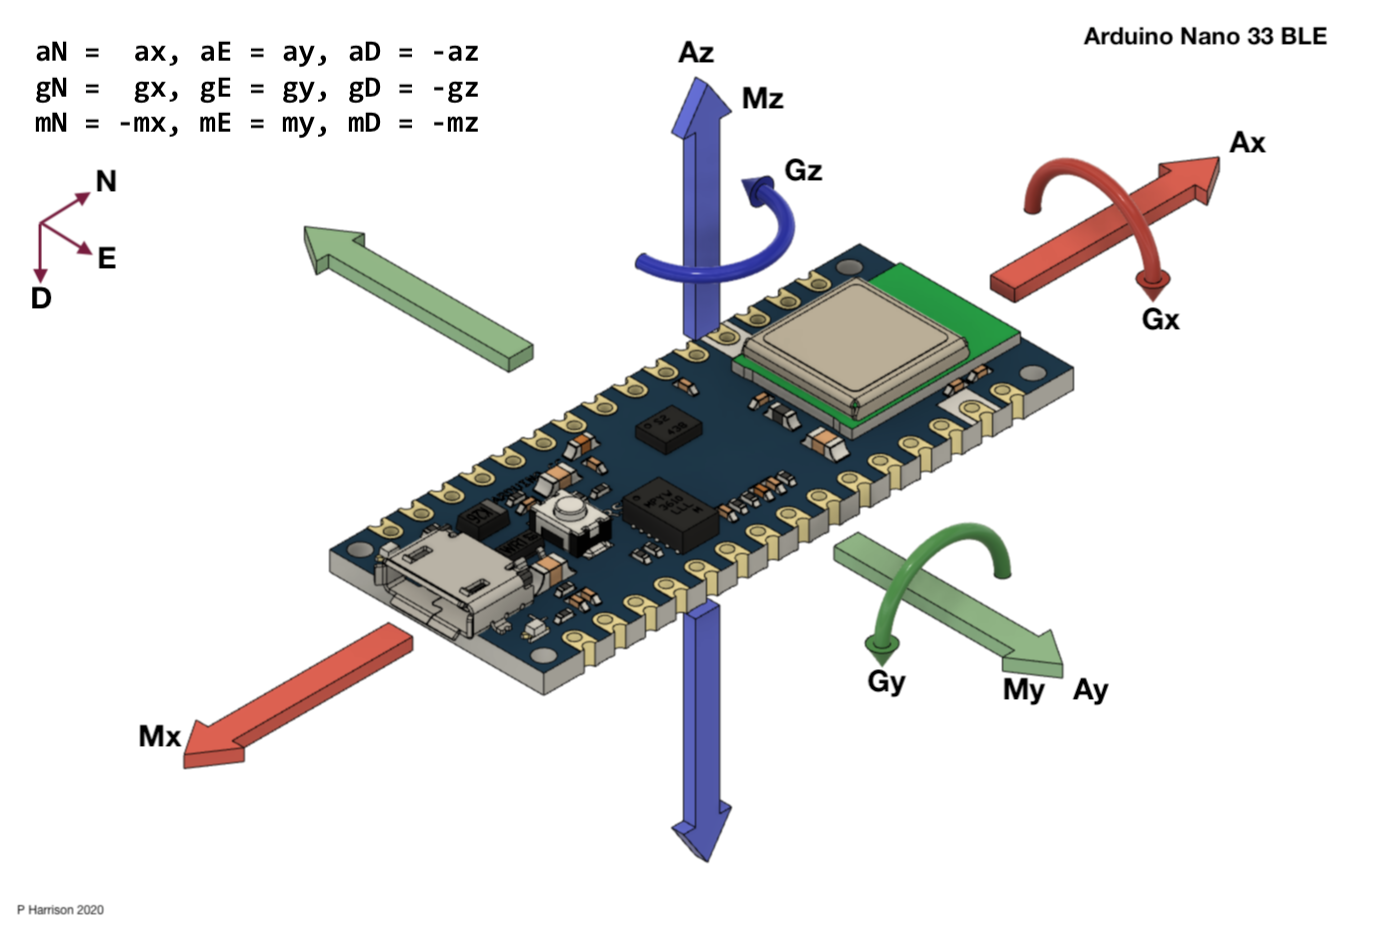

In [7]:
display(Image("Arduino_axis.PNG", retina=True))

Arduino coordinate conversion

Acc & Gyro: (x, y, z)->(y, x, z)

Mag: (x, y, z)->(y, -x, z)

Define right handed base with y pointing forward along the axis originally defined as Ax, x pointing right along the axis originally defined as Ay, and z vertical pointing upwards.

ahrs assumes x points North.

In [8]:
def swap_xy(array):
    array[0], array[1] = array[1], array[0]
    return array

def flip_axis(array, axis):
    array[axis] = -array[axis]
    return array

In [9]:
# Plotting function
def plot_xyz(xyz):
    fig, axes = plt.subplots(2,1, figsize=(12, 12), dpi = 100, gridspec_kw={'height_ratios': [3, 1]})

    fig.suptitle("Sense position", fontsize = 16)
    
    xy = axes[0].scatter(xyz["px"],xyz["py"], c=xyz["pz"].values, marker='.', s=1)
    axes[0].scatter(0,0, c='r', marker='x')
    axes[0].scatter(xyz["px"][-1],xyz["py"][-1], c='g', marker='^')
    axes[0].set_xlabel("East [m]", fontsize=14)
    axes[0].set_ylabel("North [m]", fontsize=14)
    axes[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    c = plt.colorbar(xy, ax = axes[0])
    c.set_label("Height [m]", fontsize=14)
    c.ax.tick_params(labelsize=12)

    axes[1].axhline(0, c='g')
    axes[1].axhline(120, c='r')
    axes[1].plot(xyz["pz"])
    axes[1].set_xlabel("Time [s]", fontsize=14)
    axes[1].set_ylabel("Height [m]", fontsize=14)
    axes[1].xaxis.set_major_locator(AutoDateLocator())
    axes[1].tick_params(axis='x', labelrotation = 45)
    # axes[1].set_ylim([0,120])


    for ax in axes:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="both", which="major", labelsize=12)
        ax.grid()

    fig.tight_layout()
    plt.show()

def plot_vectors(vectors):    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection="3d")

    # Define the canonical basis vectors
    basis_vectors = np.identity(3)

    # Plot the basis vectors as lines from the origin
    for basis_vector in basis_vectors:
        ax.quiver(0, 0, 0, basis_vector[0], basis_vector[1], basis_vector[2], color='k', arrow_length_ratio=0.1)
        
    # Extract the vector components
    for i, vector in enumerate(vectors):
        x, y, z = vector

        # Plot the vector as an arrow from the origin
        ax.quiver(0, 0, 0, x, y, z, color='r', arrow_length_ratio=0.1)
        
        # Add an annotation to the tip of the arrow
        ax.text(x, y, z, 'XYZ'[i], color='red')

    # Set labels and limits
    ax.set_xlabel('E')
    ax.set_ylabel('N')
    ax.set_zlabel('Z')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    ax.set_box_aspect(None, zoom = 0.9)
    
    fig.tight_layout()
    
    plt.show()


In [10]:
# Vector rotation functions
def compute_rotation(v1, v2):
    # Normalize the input vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)

    # Calculate the axis of rotation
    axis_x = np.cross(v1_norm, v2_norm)
    axis_y = np.cross(v1_norm, axis_x)

    # Calculate the angle of rotation
    # angle = np.arccos(np.dot(v1_norm, v2_norm))
    
    # R = Rotation.from_rotvec(axis_x*angle, degrees=False)
    R = Rotation.align_vectors([v1_norm, axis_y], [v2_norm, [-np.sign(v1_norm[2]),0,0]])[0]
    
    return R

def update_rotation(gyro, prev_rotation):
    new_rotation = Rotation.from_rotvec(gyro, degrees=False)
    
    # Update rotation matrix using the previous rotation matrix
    updated_rotation = new_rotation * prev_rotation
    
    return updated_rotation


In [32]:
wgs = ahrs.utils.WGS()
madgwick = ahrs.filters.Madgwick()

# Universal constants
lat = 53.48
g = 9.80665

gravity_versor = -np.array([0.0, 0.0, 1.0])
gravity_unit = wgs.normal_gravity(lat)
gravity = gravity_versor * gravity_unit/g

# Resolution constants
accelerometer_resolution = 0.122 * 1e-3
gyroscope_resolution = 70 * 1e-3
magnetometer_resolution = 14 * 1e-3

# Calibration constants
initial_orientation = Rotation.identity().as_quat()
accelerometer_offsets = np.array([0.0, 0.0, 0.0])
gyroscope_offsets = np.array([0.0, 0.0, 0.0])
magnetometer_offsets = np.array([0.0, 0.0, 0.0])

def calibrate_sensors(sensor_data, start = 1, window = 10, plot = False):
    global initial_orientation
    global accelerometer_offsets
    global gyroscope_offsets
    global magnetometer_offsets
    
    begin = sensor_data.index[0]+pd.Timedelta(seconds=start)
    end = begin+pd.Timedelta(seconds=window)
    offsets = sensor_data.loc[begin:end]
    dt = np.diff(sensor_data.loc[begin:end].index)/pd.Timedelta(seconds=1)
    described = offsets.describe().T
    median_offsets = described["50%"]
    described["Error"] = described["std"]/described["mean"]
    print(f"Raw offsets:\n{described.to_string()}\n")
    
    raw_acc_array = offsets[["Acc x","Acc y","Acc z"]].to_numpy() # Raw accelerometer readings
    aligned_acc_array = np.array([swap_xy(a) for a in raw_acc_array])
    median_aligned_acc = np.median(aligned_acc_array, axis=0)
    print(f"Median aligned accelerometer: {median_aligned_acc} g")
    
    raw_gyro_array = offsets[["Gyro x","Gyro y","Gyro z"]].to_numpy() # Raw gyroscope readings
    aligned_gyro_array = np.array([swap_xy(g) for g in raw_gyro_array])
    median_aligned_gyro = np.median(aligned_gyro_array, axis=0)
    print(f"Median aligned gyroscope: {median_aligned_gyro} deg/s")
    
    raw_mag_array = offsets[["Mag x","Mag y","Mag z"]].to_numpy() # Raw gyroscope readings
    aligned_mag_array = np.array([flip_axis(swap_xy(m),1) for m in raw_mag_array])
    median_aligned_mag = np.median(aligned_mag_array, axis=0)
    print(f"Median aligned magnetometer: {median_aligned_mag} uT")
    
    initial_rotation = compute_rotation(median_aligned_acc, gravity)
     
    rotated_mag = initial_rotation.apply(median_aligned_mag) * 1e6 # uT -> T to avoid numeric errors
    north_correction = -np.arctan2(rotated_mag[0], rotated_mag[1])
    print(f"\nNorth correction: {round(np.degrees(north_correction), 2)} deg")
    
    initial_rotation = update_rotation([0, 0, north_correction], initial_rotation)
    aligned_rotation = initial_rotation
    initial_rotation = update_rotation([0, 0, -np.pi/2], initial_rotation)
    initial_orientation = initial_rotation.as_quat()
    
    print(f"\nInitial orientation: {initial_orientation}")
    print(f"Initial rotation matrix:\n{initial_rotation.as_matrix()}\n")
    if plot:
        plt.matshow(initial_rotation.as_matrix())
        plot_vectors(aligned_rotation.as_matrix().T)

    rotated_acc = initial_rotation.apply(median_aligned_acc)
    accelerometer_offsets = swap_xy(rotated_acc - gravity)
    print(f"Accelerometer offsets: {accelerometer_offsets} g")


    
    print(f"Gyroscope offsets: {gyroscope_offsets} deg/s")
    
    print(f"Magnetometer offsets: {magnetometer_offsets} uT")

In [12]:
def process_sensor_data(sensor_data, start = pd.Timedelta(seconds = 0)):
    position_list = [np.array([0.0, 0.0, 0.0])]  # List to store the calculated positions
    velocity_list = [np.array([0.0, 0.0, 0.0])]
    acceleration_list = [np.array([0.0, 0.0, 0.0])]
    
    start = sensor_data.index[0]+start
    sensor_data = sensor_data.loc[start:]
        
    for idx, (timestamp, row) in enumerate(tqdm(sensor_data.iterrows(), total=sensor_data.shape[0])):
        ax = row["Acc x"]
        ay = row["Acc y"]
        az = row["Acc z"]
        wx = row["Gyro x"]
        wy = row["Gyro y"]
        wz = row["Gyro z"]
        mx = row["Mag x"]
        my = row["Mag y"]
        mz = row["Mag z"]

        acc = np.array([ax, ay, az]) - accelerometer_offsets # Raw acceleration readings
        acc = swap_xy(acc) # Need to swap x and y to form right handed basis
        
        gyro = np.array([wx, wy, wz]) - gyroscope_offsets # Raw gyro readings
        gyro = swap_xy(gyro) # Need to swap x and y to form right handed basis
        gyro = np.radians(gyro)
        
        mag = np.array([mx, my, mz]) - magnetometer_offsets # Raw magnetometer readings
        mag = flip_axis(swap_xy(mag), 1) * 1e-3 # uT -> nT # Need to swap x and y and flip y to form right handed basis
        
        if idx == 0:
            # Initialize first timestamp and rotation matrix
            prev_timestamp = timestamp
            prev_orientation = initial_orientation
            prev_acc = acc
            prev_gyro = gyro
            prev_mag = mag

            continue

        if all(abs(acc - prev_acc) < accelerometer_resolution):
            mean_acc = prev_acc
        else:
            mean_acc = (acc + prev_acc) / 2
            prev_acc = acc
            
        if all(abs(gyro - prev_gyro) < gyroscope_resolution):
            mean_gyro = prev_gyro
        else:
            mean_gyro = (gyro + prev_gyro) / 2
            prev_gyro = gyro
             
        if all(abs(mag - prev_mag) < magnetometer_resolution):
            mean_mag = prev_mag
        else:
            mean_mag = (mag + prev_mag) / 2
            prev_mag = mag
        
        # Convert timestamp to time in seconds
        dt = (timestamp - prev_timestamp) / pd.Timedelta(seconds=1)
        prev_timestamp = timestamp
        
        orientation = madgwick.updateMARG(q=prev_orientation, acc=mean_acc, mag=mean_mag, gyr=mean_gyro, dt=dt)
        prev_orientation = orientation
        rotation = Rotation.from_quat(orientation)
        rotation = update_rotation([0, 0, -np.pi/2], rotation)
        
        # Rotate the linear acceleration vector into the canonical XYZ coordinates
        rotated_acceleration = rotation.apply(mean_acc)
        
        # Remove gravity component from acceleration
        normalized_acceleration = rotated_acceleration - gravity
        acceleration = normalized_acceleration #* gravity_unit #m/s^2
        acceleration_list.append(acceleration)

        # Integrate the rotated linear acceleration to determine velocity
        velocity = np.mean(acceleration_list[-2:], axis=0) * dt + velocity_list[-1]
        velocity_list.append(velocity)

        # Integrate velocity to determine position
        position = np.mean(velocity_list[-2:], axis=0) * dt + position_list[-1]
        position_list.append(position)

    # Create a pandas DataFrame from the positions list
    df_data = np.concatenate((acceleration_list, velocity_list, position_list), axis=1)
    df_columns = [i+j for i in "avp" for j in "xyz"]
    df = pd.DataFrame(df_data, columns = df_columns, index = sensor_data.index)
        
    plot_vectors(rotation.as_matrix().T)
    
    rotated_mag = rotation.apply(mean_mag) * 1e6 # uT -> T to avoid numeric errors
    
    return df

Raw offsets:
             count         mean           std      min      25%      50%      75%      max         Error
_field                                                                                                  
Acc x         73.0    -0.090000  8.384297e-17    -0.09    -0.09    -0.09    -0.09    -0.09 -9.315886e-16
Acc y         73.0     0.980000  8.943251e-16     0.98     0.98     0.98     0.98     0.98  9.125766e-16
Acc z         73.0     0.030000  6.986915e-18     0.03     0.03     0.03     0.03     0.03  2.328972e-16
B             73.0     4.657534  1.271692e+00     0.00     5.00     5.00     5.00     5.00  2.730397e-01
DHT hum       73.0    51.700000  2.633597e+00    49.50    49.90    50.40    53.10    62.80  5.093998e-02
DHT temp      73.0    25.464384  5.101705e-02    25.30    25.40    25.50    25.50    25.50  2.003467e-03
G             73.0     4.657534  1.271692e+00     0.00     5.00     5.00     5.00     5.00  2.730397e-01
Gyro x        73.0     0.508082  9.627301e

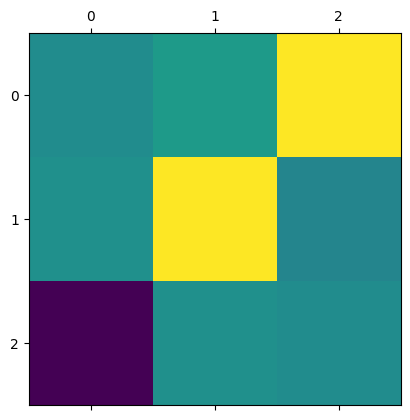

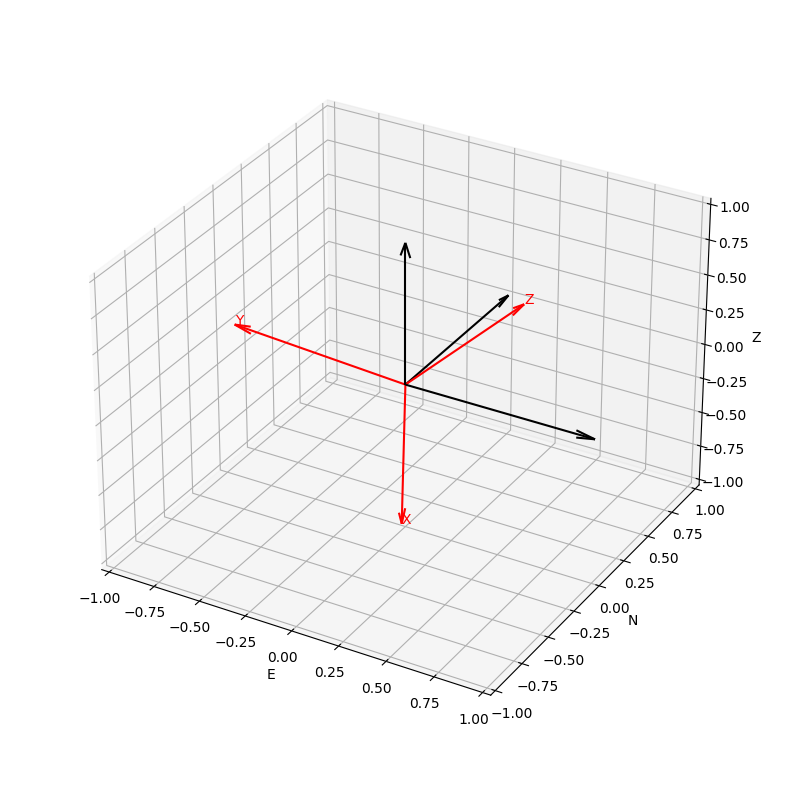

Accelerometer offsets: [-0.08965322 -0.00789409  0.02026661] g
Gyroscope offsets: [0. 0. 0.] deg/s
Magnetometer offsets: [0. 0. 0.] uT


In [34]:
calibrate_sensors(data, window = 50, start = 1, plot=True)

In [35]:
smooth_data = data.rolling(window = 5, min_periods = 1, center = True).median().drop_duplicates()

  0%|          | 0/49867 [00:00<?, ?it/s]

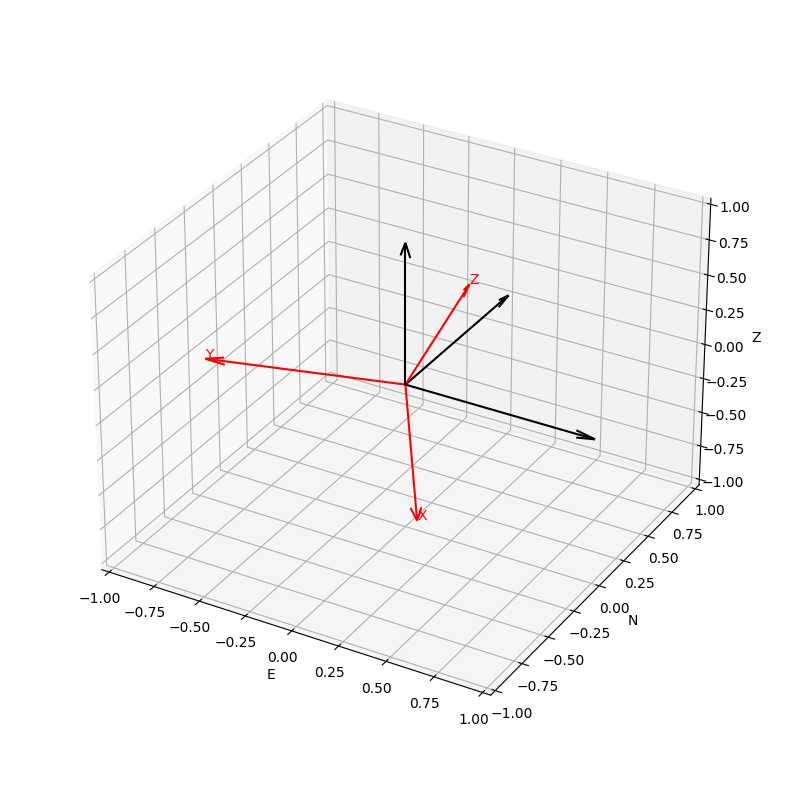

In [36]:
xyz = process_sensor_data(smooth_data, start=pd.Timedelta(seconds=60))
#xyz = process_sensor_data(data, start = pd.Timedelta(seconds=0))

## Acceleration

<Axes: xlabel='_time'>

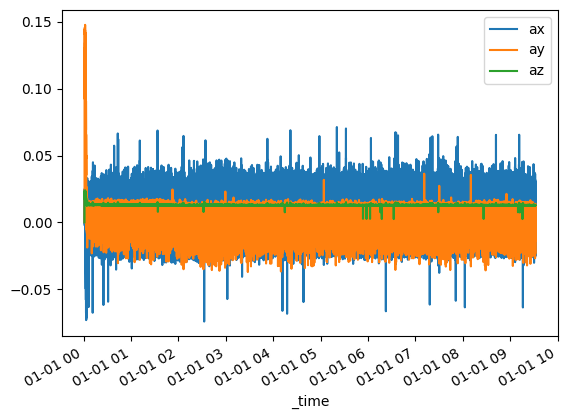

In [37]:
xyz.filter(like="a").plot()

In [38]:
xyz.filter(like="a").mean()

ax    0.005652
ay   -0.005069
az    0.012700
dtype: float64

ax    0.114569
ay    0.001542
az   -0.006795
dtype: float64

<Axes: xlabel='_time'>

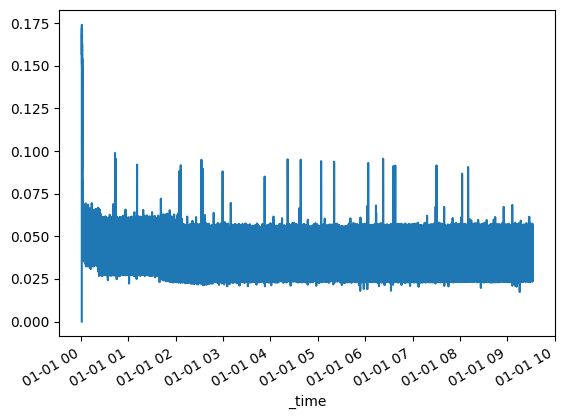

In [18]:
xyz.filter(like="a").apply(np.linalg.norm, axis=1).plot()

## Velocity

<Axes: xlabel='_time'>

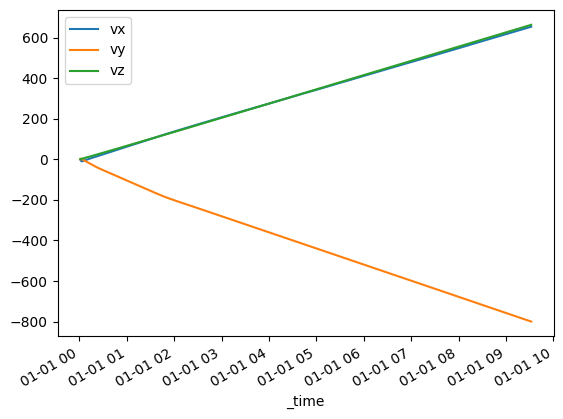

In [19]:
xyz.filter(like="v").plot()

In [20]:
xyz.filter(like="v").sum()

vx    1.625962e+07
vy   -2.082957e+07
vz    1.643504e+07
dtype: float64

## Position

<Axes: xlabel='_time'>

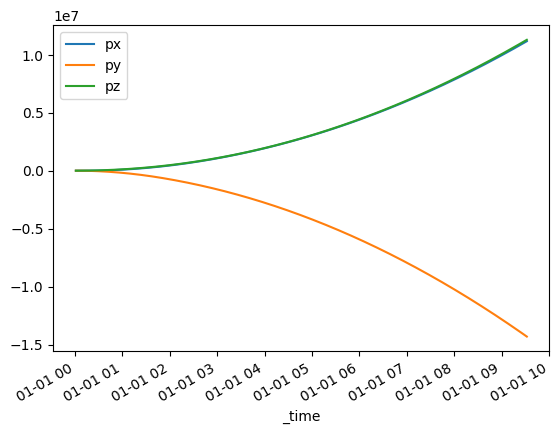

In [21]:
xyz.filter(like="p").plot()

In [22]:
xyz.filter(like="p").sum()

px    1.847820e+11
py   -2.462913e+11
pz    1.868225e+11
dtype: float64

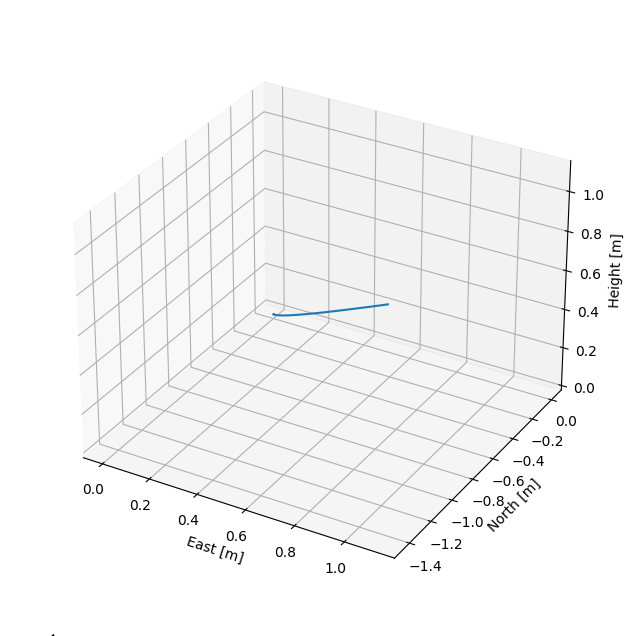

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz["px"],xyz["py"],xyz["pz"])
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_zlabel("Height [m]")
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
# ax.set_aspect("equal", adjustable='box')
ax.set_box_aspect(None, zoom = 0.9)
plt.show()

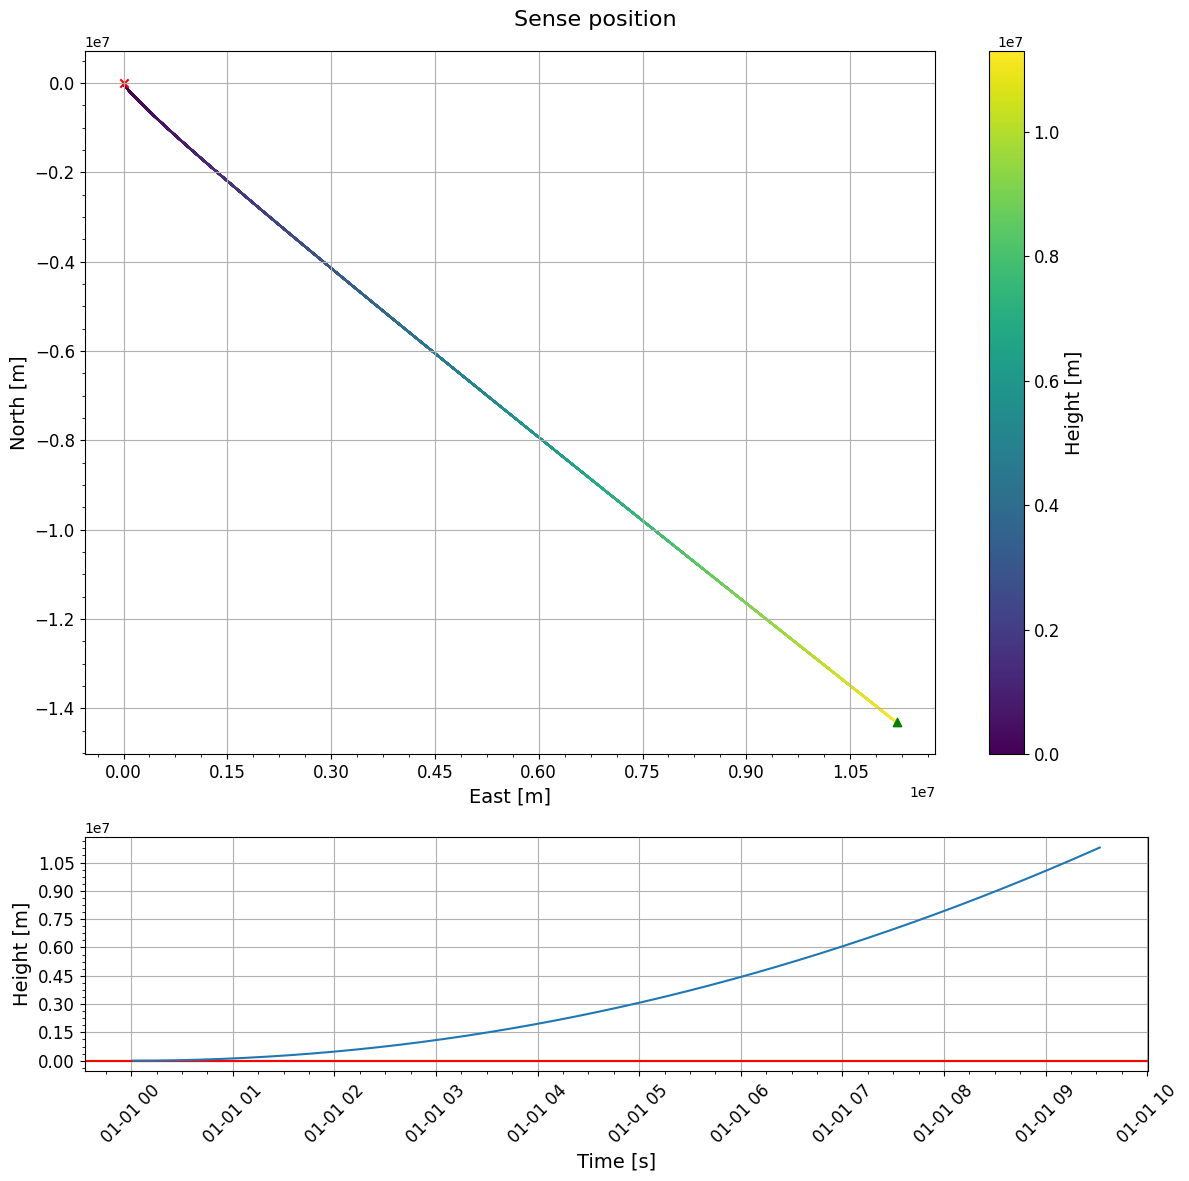

In [24]:
plot_xyz(xyz)

## Raw data 

### Accelerometer

<Axes: xlabel='_time'>

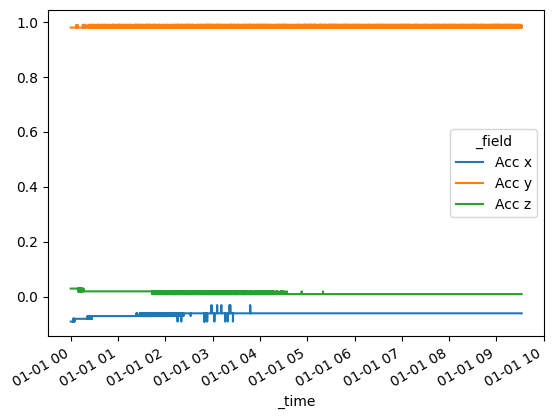

In [25]:
data.filter(like = "Acc ").plot()

<Axes: xlabel='_time'>

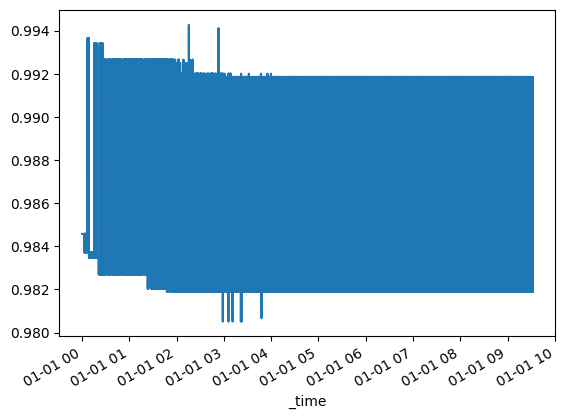

In [26]:
data.filter(like = "Acc").apply(np.linalg.norm, axis=1).plot()

### Gyroscope

<Axes: xlabel='_time'>

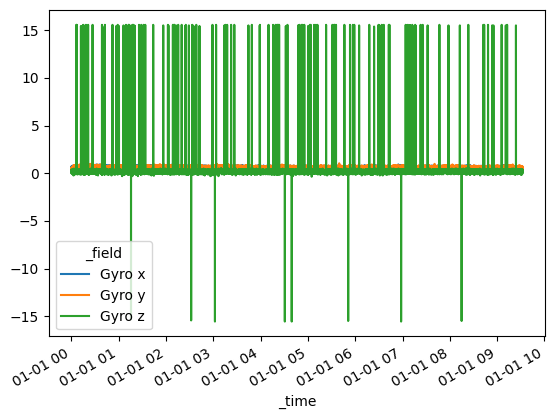

In [27]:
data.filter(like = "Gyro ").plot()

In [28]:
data.filter(like = "Gyro ").mean()

_field
Gyro x    0.556868
Gyro y    0.548275
Gyro z    0.217543
dtype: float64

<Axes: xlabel='_time'>

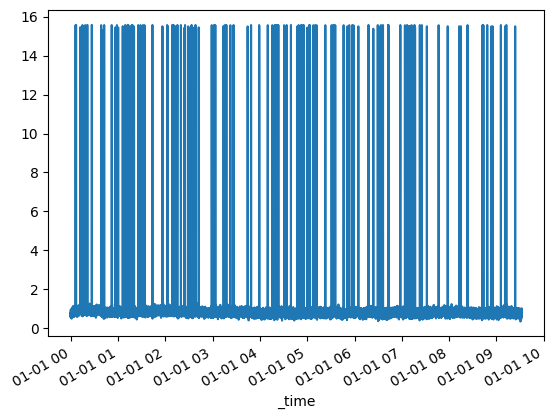

In [29]:
data.filter(like = "Gyro").apply(np.linalg.norm, axis=1).plot()

### Magnetometer

<Axes: xlabel='_time'>

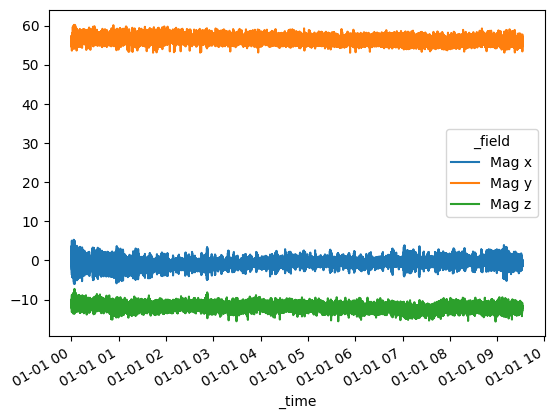

In [30]:
data.filter(like = "Mag").plot()

<Axes: xlabel='_time'>

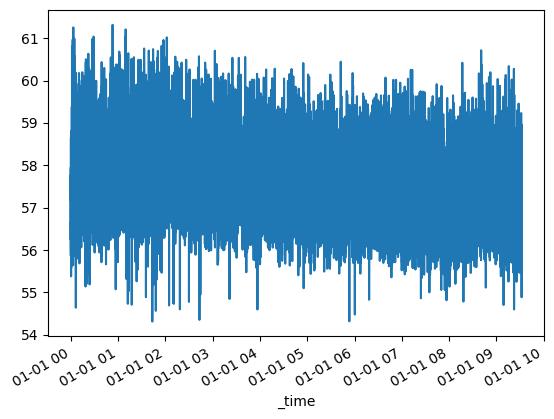

In [31]:
data.filter(like = "Mag").apply(np.linalg.norm, axis=1).plot()